In [1]:
import sys
sys.path.append('..')
from src.evo_eq_model import *
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys


if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [2]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k
        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = 1.5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]
    return ts, solution

In [3]:
R0, kappa = 1.5, 0
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]


In [4]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [5]:
R0, kappa = 2.5, 1e4
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10
R_d
ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

fit_d = lambda x,y,z, d_over_xi: R0/(1+y*kappa) * ( x + (1- np.exp(-d_over_xi))*z )-1
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)


simple_sel = lambda z, d_over_xi: (1-np.exp(-d_over_xi))*z#/(1-z)

p_surv = lambda x,y,z, d_over_xi: get_p_surv_inv_int(fit_d(x,y,z,d_over_xi=d_over_xi), dt=dt,reg= 1e-1)

def plot_f_s_pi(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]

    for d in tqdm(ds,disable=tqdm_disabled):
        fit = fit_d(x,y,z,d/xi)
        sel = sel_d(x,y,z,d/xi)

        line_d, = ax.plot(ts,fit, label = fr'$\frac{{d}}{{\xi}}={d/xi:.2f}$',alpha=.5)

        line_sel, = ax.plot(ts,sel,  color = line_d.get_color(), linestyle='--')#,label = f'sel d={d}',)

        ax.plot(ts,p_surv(x,y,z,d/xi),  color = line_d.get_color(), linestyle=':')#,label = f'p_surv d={d}',)
        ax.plot(ts,sel/(1+sel),  color = line_d.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
    
    handles= ax.get_legend_handles_labels()[0]
    handles = handles +[
        Line2D([0], [0], color='k', lw=2, label='fit'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label='selection'),
        Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$\pi_d(t)$ (inhomogeneous branching)'),
    ]

    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)
    ax.axvline(tp, color='k', linestyle='--')

    ax.set_xscale('log')
    ax.set_yscale('log')

def plot_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False):
    tp = ts[np.argmax(y)]
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)

            line_y_psurv, = ax.plot(ts,y * p_surv(x,y,z,d/xi), linestyle=':')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel/(1+sel),  color = line_y_psurv.get_color(), linestyle='-.')#,label = f'p_surv d={d}',)
            ax.plot(ts,y * sel,  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle=':', label=r'$y(t) \pi_d(t)$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$y(t) \frac{s_d(t)}{1 + s_d(t)}$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y(t) s_d(t)$'),
]
    ax.axvline(tp, color='k', linestyle='--')
    # ax.legend(handles=handles,loc='best', fontsize=legend_fontsize)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e-4)

def plot_integral_y_psurv(ax, x,y,z, ts, ds, xi, legend_fontsize=20, tqdm_disabled=False, logscales =False, return_fits = False):
    tp = ts[np.argmax(y)]
    dt = ts[1]-ts[0]
    list_fits = []
    for d in tqdm(ds,disable=tqdm_disabled):
            fit = fit_d(x,y,z,d/xi)
            sel = sel_d(x,y,z,d/xi)
            cum_y_p_surv = np.cumsum(y * p_surv(x,y,z,d/xi))*dt
            #fit cum_y_p_surv with quadratic
            line_y_psurv, = ax.plot(ts[cum_y_p_surv<np.max(cum_y_p_surv)], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)], linestyle='-',alpha=.5)#,label = f'p_surv d={d}',

            p = np.polyfit(ts[cum_y_p_surv<np.max(cum_y_p_surv)*.75], cum_y_p_surv[cum_y_p_surv<np.max(cum_y_p_surv)*.75], 2)
            list_fits.append(p)

            ax.plot(ts, np.polyval(p,ts), linestyle=':', color = line_y_psurv.get_color(), alpha=.5)
            
            ax.plot(ts,np.cumsum(y * sel/(1+sel)*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5)#,label = f'p_surv d={d}',)

            sim_sel = simple_sel(z,d/xi)
            sim_pi = sim_sel/(1+sim_sel)
            ax.plot(ts,np.cumsum(y * sim_sel*dt),  color = line_y_psurv.get_color(), linestyle='-.', alpha=.5,marker='x', markevery=1000)#,label = f'p_surv d={d}',)

            # ax.plot(ts,np.cumsum(y * sel*dt),  color = line_y_psurv.get_color(), linestyle='--',alpha=.5)#,label = f'p_surv d={d}',)

    # ax.plot(ts, ts/(6*N), color='k', linestyle='--')
    ax.plot(ts, ts**2/(500*N), color='k', linestyle=':')

    # ax.annotate(r'$\sim t$', (ts[len(ts)//10], ts[len(ts)//10]*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)
    ax.annotate(r'$\sim t^2$', (ts[len(ts)//10], ts[len(ts)//10]**2*(1.5)/(4*N)), textcoords="offset points", xytext=(0,10), ha='center', fontsize=20)

    handles= []

    handles = handles +[
    Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\int_0^t y(t) \pi_d(t) dt$ (inhomogeneous branching)'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label=r'$\int_0^t y(t) \frac{s_d(t)}{1 + s_d(t)} dt$ (adiabatic)'),
    Line2D([0], [0], color='k', lw=2, linestyle=':', label='quadratic fit'),
    # Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$\int_0^t y(t) s_d(t) dt$'),

]
    ax.axvline(tp, color='k', linestyle='--')
    ax.legend(handles=handles,loc=(1.01,.1), fontsize=legend_fontsize)

    if logscales:
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_ylim(bottom= 0,top=.35)
        ax.set_xlim(left=ts[1], right=5*kappa/R0)
    if return_fits:
        return np.array(list_fits)

In [6]:
fit_d = lambda x,y,z, d_over_xi: R0/(1+y*kappa) * ( x + (1- np.exp(-d_over_xi))*z )-1
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)



In [7]:
np.log10(N)

7.0

Text(0.5, 0.95, '$R_0=2.5, \\kappa=1e+03,\\mu N=1e+03, \\langle d \\rangle/\\xi=0.2, N= 1e+08$')

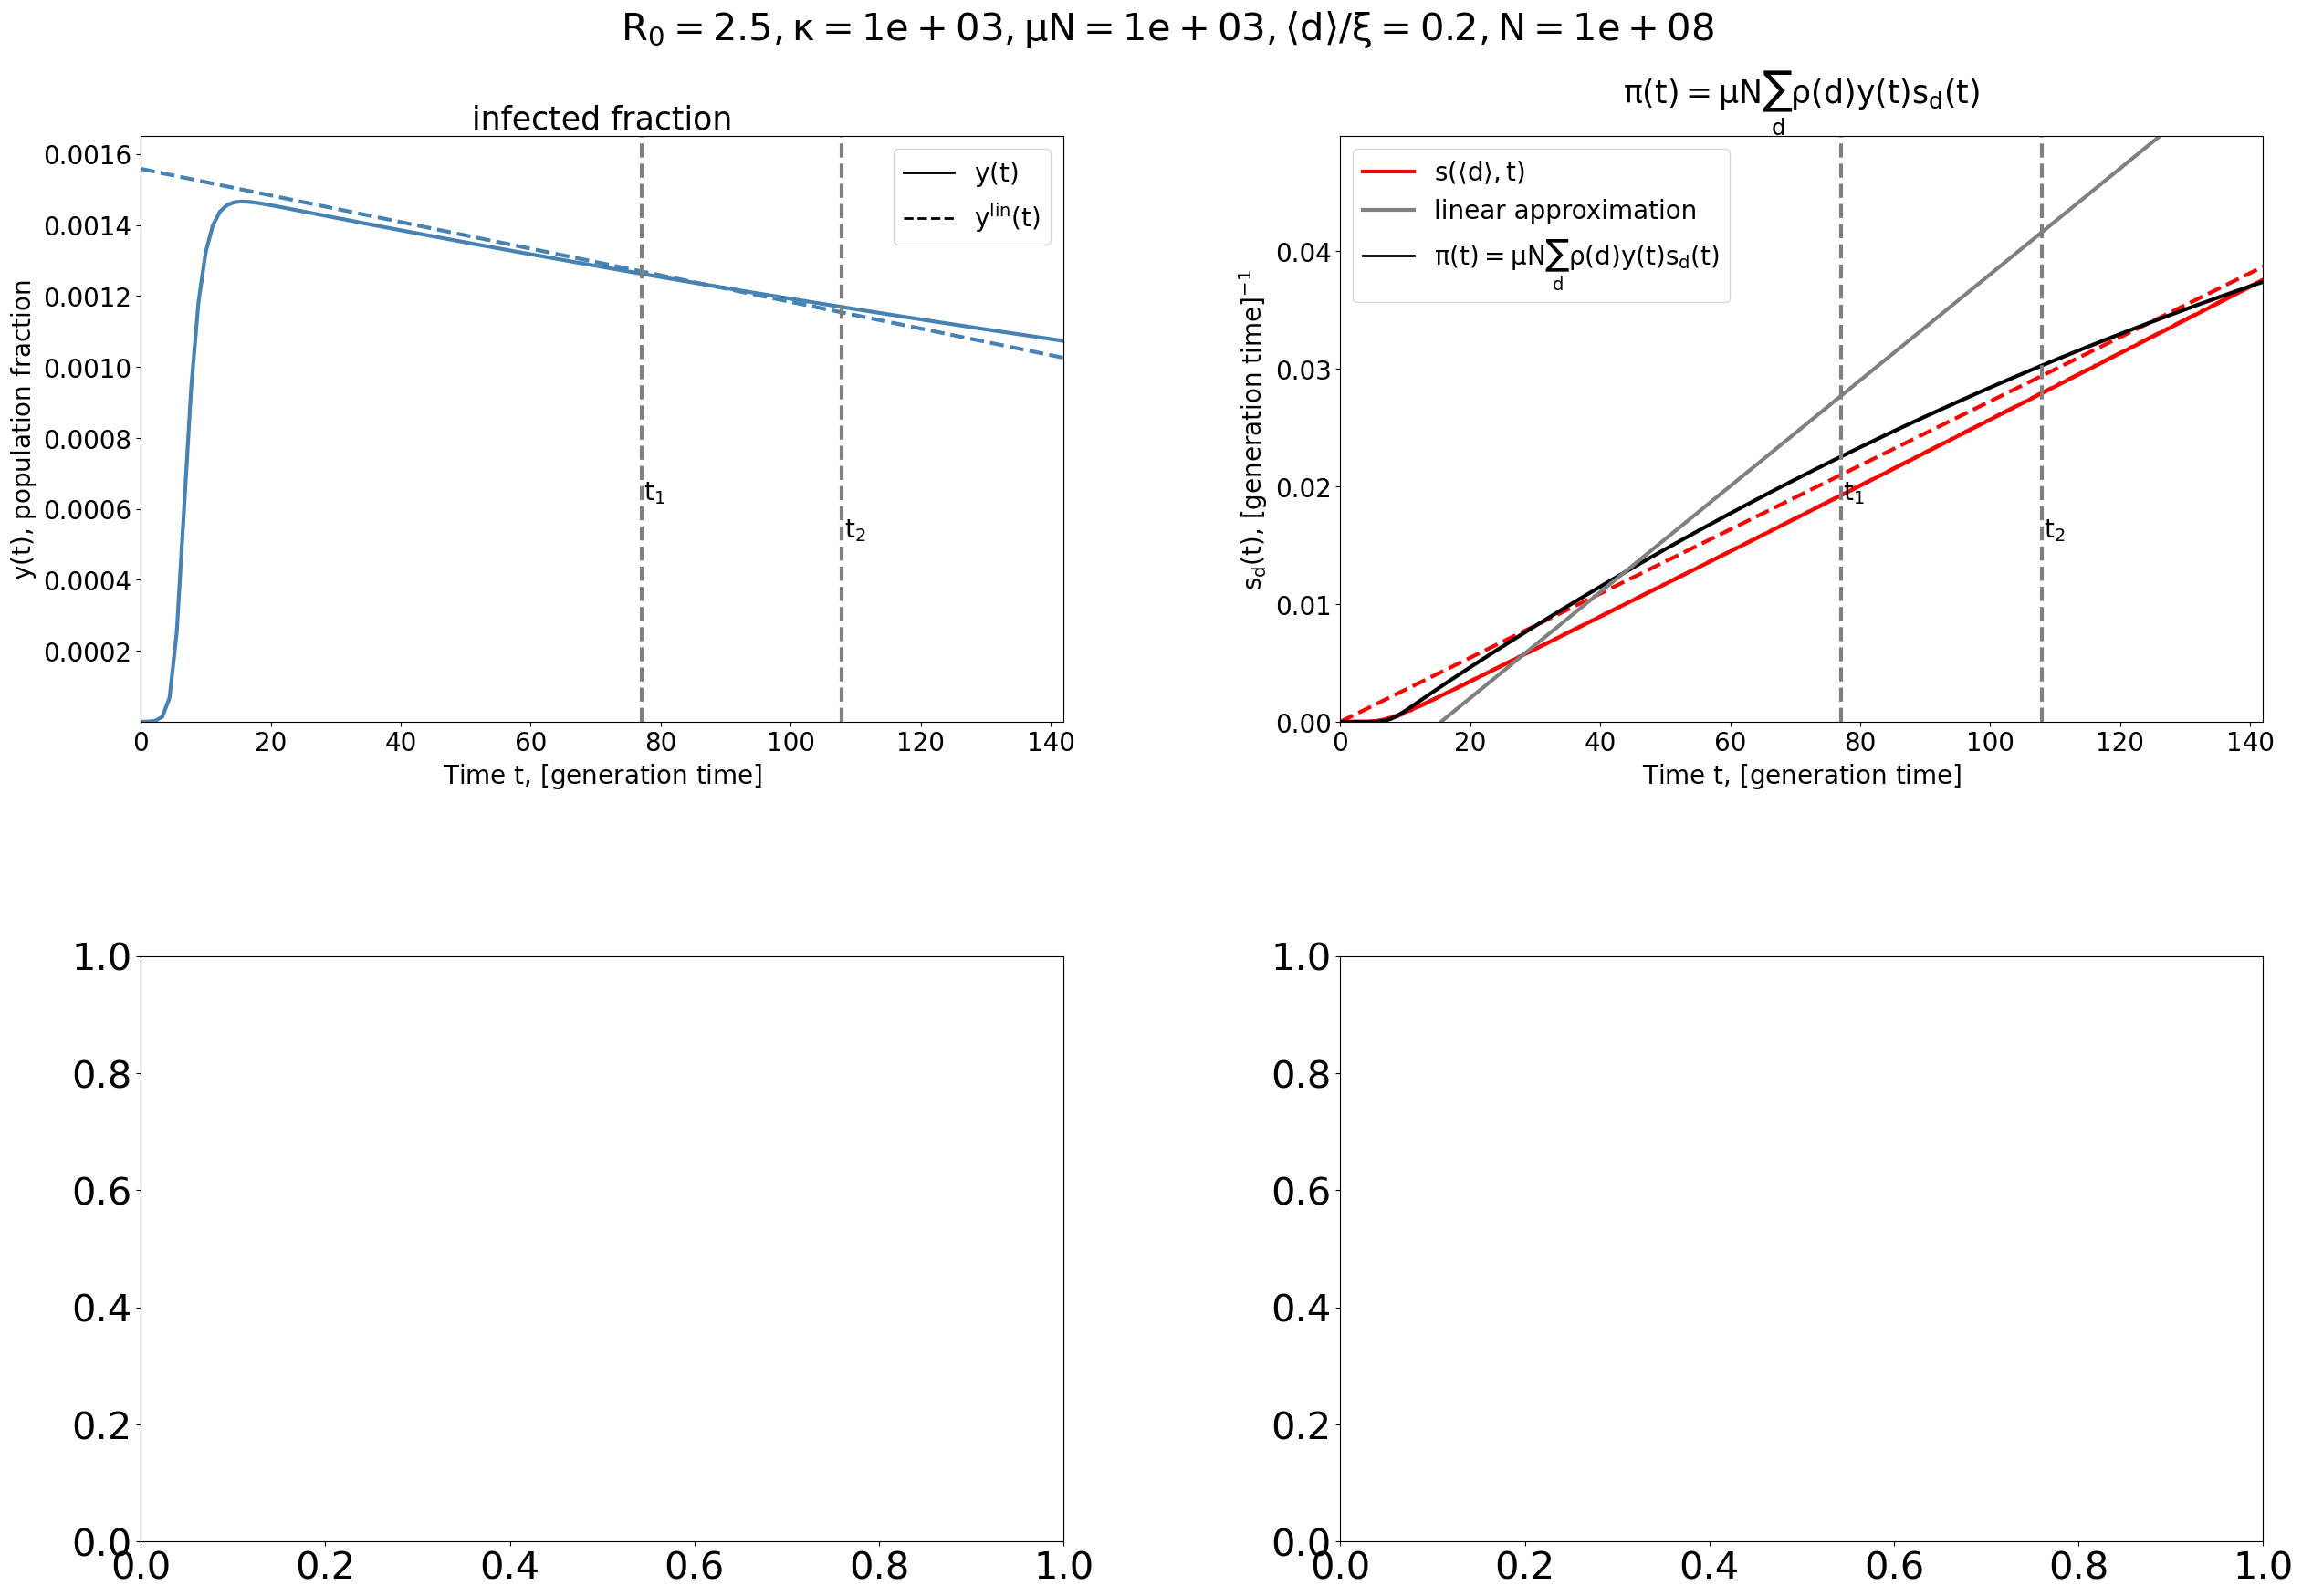

In [8]:


# zp = lambda R0,kappa: R0/kappa * (np.log((R0-1)*kappa**2 /(R0**2))- (R0-1)/R0)
zp = lambda R0,kappa: 0
yp = lambda R0,kappa: (R0-1)/kappa
zinf= lambda R0,kappa: 1- 1/R0 + 1/kappa
c_d= lambda d_over_xi: np.exp(-d_over_xi)
sel_d = lambda x,y,z,d_over_xi: fit_d(x,y,z,d_over_xi) - fit_d(x,y,z,0)



# -zp (-1 + c[d]) - (R0 t (zinf - zp) (-1 + c[d]))/\[Kappa]
c_d = lambda d_over_xi: np.exp(-d_over_xi)
lin_sel_d = lambda t, d_over_xi, R0,kappa: zp(R0,kappa) * (1 - c_d(d_over_xi)) \
    + (R0 * t * (zinf(R0,kappa) - zp(R0,kappa)) * (1 - c_d(d_over_xi)))/kappa

lin_sel_2_d = lambda t, d_over_xi, R0,kappa: (1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa)/(1-(1-c_d(d_over_xi)) *(zinf(R0,kappa)*R0*t/kappa))

sel_lin_z_d = lambda z, d_over_xi: (1 - c_d(d_over_xi)) *z/(1-z)


R0, kappa = 2.5, 1e3

mu = 1e-7
N = 1e8
muN_1= 1000
p_alpha= .1
subtitles_fontsize=25

ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]
dt = ts[1]-ts[0]

ds_few = xi*np.logspace(-1,1,3)
ds_range= np.arange(1,20*dbar)


alpha = muN_1*(R0-1)**2 /kappa**2 
delta =dbar/xi
corr_delta = (np.exp(2/dbar)*(-1 + np.exp(1/xi)))/(dbar*(-1 + np.exp(1/dbar))*(-1 + np.exp(1/dbar + 1/xi)))
    
t1 = np.sqrt(np.pi/(2*alpha*corr_delta))
t2 = np.sqrt(9/8 * np.pi/(alpha*corr_delta))

T = np.min(ts[y<1/N])
pi_summed = np.zeros_like(ts)
pi_lin_summed = np.zeros_like(ts)
for id,d in enumerate(ds_range):
    sel = sel_lin_z_d(z,d/xi)
    sel_lin = lin_sel_2_d(ts, d/xi, R0, kappa)

    fit= fit_d(x,y,z,d/xi)
    rho_d = p_alpha*(1-p_alpha)**(d-1)
    pi_summed+= muN_1*y*sel*rho_d
    pi_lin_summed+= muN_1*y*sel_lin*rho_d

lowest_order= True


fig,ax = plt.subplots(2,2,figsize=(30,20))
# ax= np.roll(ax.flatten(),-3)
ax= ax.flatten()
plt.subplots_adjust(hspace=.4, wspace=.3)

ax_upper = ax[0:2]
ax_lower = ax[2:4]
block_axinf= True
axinf = ax[0]
##axinf --> Infected
if block_axinf:
    ylin = yp(R0,kappa)*(1-R0/kappa*(ts-tp))
    yquad = yp(R0,kappa)*(1-R0/kappa*ts + R0**2/(2*kappa**2)*ts**2- R0**3/(6*kappa**3)*ts**3)

    axinf.plot(ts,y,color='steelblue',linestyle='-')
    axinf.plot(ts[ylin>0],ylin[ylin>0],color='steelblue',linestyle='--')

    # axinf.set_yscale('log')
    axinf.set_ylim(1/N,yp(R0,kappa)*1.1)

    axinf.set_title('infected fraction', fontsize=subtitles_fontsize)
    axinf.set_ylabel(r'$y(t)$, population fraction', fontsize=20)

    handles0 = axinf.get_legend_handles_labels()[0]
    handles0=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$y(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y^\mathrm{lin}(t)$'),
    ]
    axinf.legend(handles=handles0,loc='best', fontsize=20)

###ax_selection --> Selection vs rate
plot_selection= True
ax_selection = ax[1]
if plot_selection:
    d = dbar
    sel = sel_d(x,y,z,d/xi)
    ls = ax_selection.plot(ts,sel, label = fr'$s(\langle d\rangle, t)$',color='red')
    
    sel_lin_z = sel_lin_z_d(z,d/xi)
    ax_selection.plot(ts,sel_lin_z, color = ls[0].get_color(), linestyle='-.')

    lin_sel = lin_sel_d(ts, d/xi, R0, kappa)
    ax_selection.plot(ts[lin_sel<np.max(sel)],lin_sel[lin_sel<np.max(sel)], color = ls[0].get_color(), linestyle='--')

    ax_selection.set_title('Selection', fontsize=subtitles_fontsize)
    ax_selection.set_ylabel(r'$s_d(t)$, [generation time]$^{-1}$', fontsize=20)
    ax_selection.set_ylim(0, 2*np.sqrt(1/muN_1))
    handles_selection = ax_selection.get_legend_handles_labels()[0]
    handles_selection+=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$s_d(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$s^\mathrm{lin}_d(t)$'),
    ]
    ax_selection.legend(handles=handles_selection,loc='best', fontsize=20)
##ax_rate --> rate
linrate = True
plot_rate= True
ax_rate = ax[1]
if plot_rate:
    ax_rate.plot(ts, pi_summed, color='k', linestyle='-')#, label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$')
    # ax_rate.plot(ts, pi_lin_summed, color='green', linestyle='--', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s^\mathrm{lin}_d(t)$')
    ax_rate.set_ylim(0, muN_1*R0* 120/(kappa)*corr_delta *yp(R0,kappa)*zinf(R0,kappa))
    pi_lin = muN_1*(R0-1)**2/(kappa**2)*delta* (ts-tp)
    pi_quad = muN_1*(R0-1)**2/(kappa**2)*delta*  (1-(ts-tp)*R0/kappa)* (ts-tp)
    if linrate:
        ax_rate.plot(ts, pi_lin,color='grey',label='linear approximation')
    else:
        ax_rate.plot(ts, pi_quad,color='grey',label='quadratic approximation')
    handles_rate = ax_rate.get_legend_handles_labels()[0]+[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$'),

    ]
    ax_rate.legend(handles=handles_rate,loc='best', fontsize=20)
    ax_rate.set_title(r'$ \pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$', fontsize=subtitles_fontsize)
    ax_rate.set_ylim(ax_selection.get_ylim())

for ia, a in enumerate(ax_upper):
    a.set_xlabel(r'Time $t$, [generation time]', fontsize=20)
    a.set_xlim(0,tp+kappa/(R0-1) *6/np.sqrt(muN_1))
    a.tick_params(axis='both', which='major', labelsize=20)
    
    a.axvline(tp+t1, color='grey', linestyle='--')
    ylim_a = a.get_ylim()
    a.annotate(r'$t_1$', (tp+t1,ylim_a[1]/4), textcoords="offset points", xytext=(10,60), ha='center', fontsize=20)

    a.axvline(tp+t2,color='grey', linestyle='--')
    a.annotate(r'$t_2$', (tp+t2,ylim_a[1]/4), textcoords="offset points", xytext=(10,30), ha='center', fontsize=20)

fig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={muN_1:.0e}, \langle d \rangle/\xi={dbar/xi:.1f}, N= {N:.0e}$', fontsize=30, y=.95)


# plt.savefig(output_folder+f'est_and_selection_recap_R0_{R0}_kappa_{kappa:.0e}_muN_{muN_1:.0e}_dbar_{dbar}.pdf',bbox_inches='tight')

In [9]:
def plot_y_s_pi(ax, R0, kappa, mu, N, p_alpha, xi, subtitles_fontsize = 25):
    ax = ax.flatten()
    assert len(ax)==2, f'ax should have length 2, not {len(ax)}'


    dbar = 1/p_alpha
    muN = mu*N
    
    ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
    x,y = S/N, I/N
    z = 1-x-y
    tp = ts[np.argmax(y)]
    dt = ts[1]-ts[0]
    ds_range= np.arange(1,20*dbar)
    pi_summed = np.zeros_like(ts)
    pi_lin_summed = np.zeros_like(ts)
    for id,d in enumerate(ds_range):
        sel = sel_lin_z_d(z,d/xi)
        sel_lin = lin_sel_2_d(ts, d/xi, R0, kappa)

        fit= fit_d(x,y,z,d/xi)
        rho_d = p_alpha*(1-p_alpha)**(d-1)
        pi_summed+= muN*y*sel*rho_d
        pi_lin_summed+= muN*y*sel_lin*rho_d
    
    alpha = muN*(R0-1)**2 /kappa**2 
    delta =dbar/xi
    corr_delta = (np.exp(2/dbar)*(-1 + np.exp(1/xi)))/(dbar*(-1 + np.exp(1/dbar))*(-1 + np.exp(1/dbar + 1/xi)))
    
    t1 = np.sqrt(np.pi/(2*alpha*corr_delta))
    t2 = np.sqrt(9/8 * np.pi/(alpha*corr_delta))

    T = np.min(ts[y<1/N])
    

    lowest_order= True

    block_axinf= True
    axinf = ax[0]
##axinf --> Infected
    if block_axinf:
        ylin = yp(R0,kappa)*(1-R0/kappa*(ts-tp))
        yquad = yp(R0,kappa)*(1-R0/kappa*ts + R0**2/(2*kappa**2)*ts**2- R0**3/(6*kappa**3)*ts**3)

        axinf.plot(ts,y,color='steelblue',linestyle='-')
        axinf.plot(ts[ylin>0],ylin[ylin>0],color='steelblue',linestyle='--')

    # axinf.set_yscale('log')
        axinf.set_ylim(1/N,yp(R0,kappa)*1.1)

        axinf.set_title('infected fraction', fontsize=subtitles_fontsize)
        axinf.set_ylabel(r'$y(t)$, population fraction', fontsize=20)

        handles0 = axinf.get_legend_handles_labels()[0]
        handles0=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$y(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$y^\mathrm{lin}(t)$'),
    ]
        axinf.legend(handles=handles0,loc='best', fontsize=20)

###ax_selection --> Selection vs rate
    plot_selection= True
    ax_selection = ax[1]
    if plot_selection:
        d = dbar
        sel = sel_d(x,y,z,d/xi)
        ls = ax_selection.plot(ts,sel, label = fr'$s(\langle d\rangle, t)$',color='red')
    
        sel_lin_z = sel_lin_z_d(z,d/xi)
        ax_selection.plot(ts,sel_lin_z, color = ls[0].get_color(), linestyle='-.')

        lin_sel = lin_sel_d(ts, d/xi, R0, kappa)
        ax_selection.plot(ts[lin_sel<np.max(sel)],lin_sel[lin_sel<np.max(sel)], color = ls[0].get_color(), linestyle='--')

        ax_selection.set_title('Selection', fontsize=subtitles_fontsize)
        ax_selection.set_ylabel(r'$s_d(t)$, [generation time]$^{-1}$', fontsize=20)
        ax_selection.set_ylim(0, 2*np.sqrt(1/muN))
        handles_selection = ax_selection.get_legend_handles_labels()[0]
        handles_selection+=[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$s_d(t)$'),
        Line2D([0], [0], color='k', lw=2, linestyle='--', label=r'$s^\mathrm{lin}_d(t)$'),
    ]
        ax_selection.legend(handles=handles_selection,loc='best', fontsize=20)
##ax_rate --> rate
    linrate = True
    plot_rate= True
    ax_rate = ax[1]
    if plot_rate:
        ax_rate.plot(ts, pi_summed, color='k', linestyle='-')#, label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$')
    # ax_rate.plot(ts, pi_lin_summed, color='green', linestyle='--', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s^\mathrm{lin}_d(t)$')
        # ax_rate.set_ylim(0, muN*R0* 120/(kappa)*corr_delta *yp(R0,kappa)*zinf(R0,kappa))
        pi_lin = muN*(R0-1)**2/(kappa**2)*delta* (ts-tp)
        pi_quad = muN*(R0-1)**2/(kappa**2)*delta*  (1-(ts-tp)*R0/kappa)* (ts-tp)
        if linrate:
            ax_rate.plot(ts, pi_lin,color='grey',label=r'$\pi(t)$, linear approximation')
        else:
            ax_rate.plot(ts, pi_quad,color='grey',label=r'$\pi(t)$, quadratic approximation')
        handles_rate = ax_rate.get_legend_handles_labels()[0]+[
        Line2D([0], [0], color='k', lw=2, linestyle='-', label=r'$\pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$'),
    ]
        ax_rate.legend(handles=handles_rate,loc='best', fontsize=20)
        ax_rate.set_title(r'$ \pi(t) = \mu N\sum_d \rho(d)y(t)s_d(t)$', fontsize=subtitles_fontsize)
        ax_rate.set_ylim(ax_selection.get_ylim())

    for ia, a in enumerate(ax):
        a.set_xlabel(r'Time $t$, [generation time]', fontsize=20)
        a.set_xlim(0,tp+kappa/(R0-1) *6/np.sqrt(muN))
        a.tick_params(axis='both', which='major', labelsize=20)
    
        a.axvline(tp+t1, color='grey', linestyle='--')
        ylim_a = a.get_ylim()
        a.annotate(r'$t_1$', (tp+t1,ylim_a[1]/4), textcoords="offset points", xytext=(10,60), ha='center', fontsize=20)

        a.axvline(tp+t2,color='grey', linestyle='--')
        a.annotate(r'$t_2$', (tp+t2,ylim_a[1]/4), textcoords="offset points", xytext=(10,30), ha='center', fontsize=20)


CI criterion 3: 0.07094305849579051
CI criterion 3: 1.25


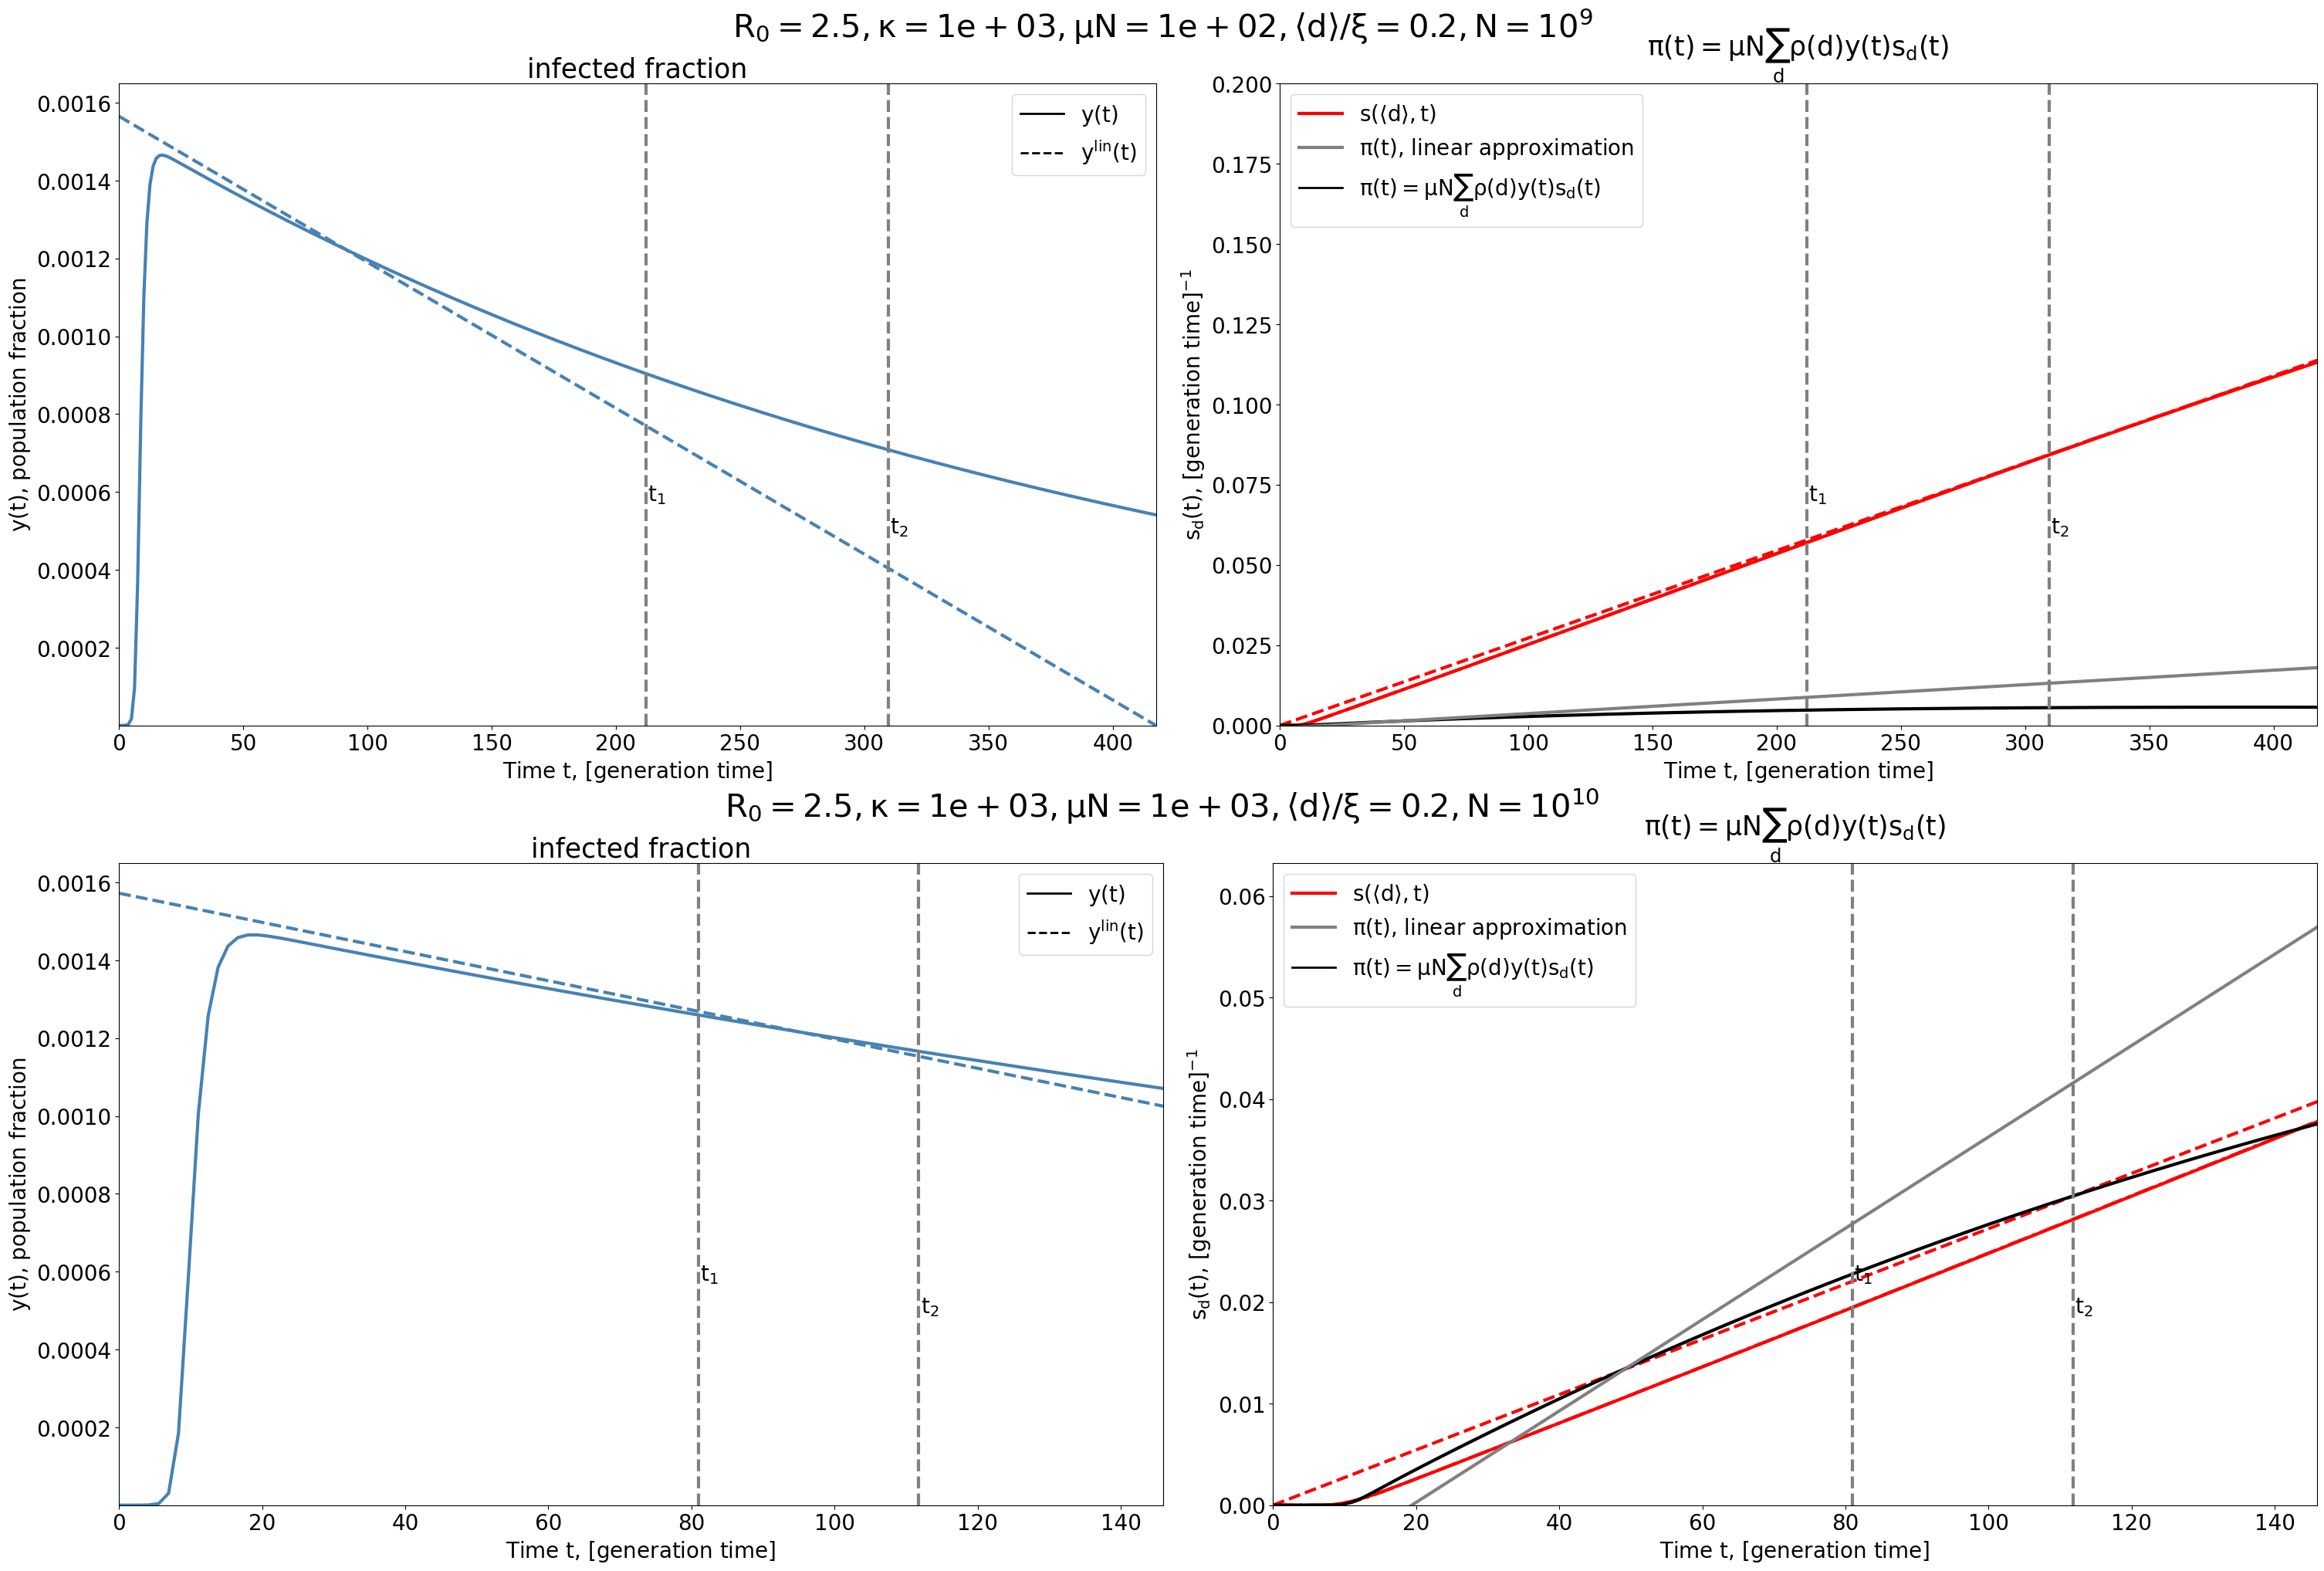

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(30, 20))
# fig.suptitle('Figure title')

# create 3x1 subfigs
mu_row = 1e-7*np.ones(2)
N_row = np.array([1e9, 1e10])
muN_row = mu_row*N_row

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    ax = subfig.subplots(nrows=1, ncols=2)

    mu = mu_row[row]
    N = N_row[row]

    # print(f'CI criterion: {mu*N*(R0-1)/kappa* delta/(1-np.exp(-delta)) *np.log(delta/(mu**2))}')
    # print(f'CI criterion2: {mu*N*(R0-1)/kappa*np.exp(-R0/((R0-1)*np.sqrt(delta)))}')
    print(f'CI criterion 3: {mu*N*(R0-1)/kappa* (1-R0/(R0-1) * np.sqrt(2/(mu*N*delta)))}')
    subfig.suptitle(fr'$R_0={R0}, \kappa={kappa:.0e},\mu N={mu*N:.0e}, \langle d \rangle/\xi={dbar/xi:.1f}, N= 10^{{{np.log10(N):.0f}}}$', fontsize=30, y=1.02)
    plot_y_s_pi(ax, R0, kappa, mu, N, p_alpha, xi, subtitles_fontsize = 25)

figname = lambda R0, kappa, muN_row, dbar: f'est_and_selection_comparison_R0_{R0}_kappa_{kappa:.0e}_muN1_{muN_row[0]:.0e}_muN2_{muN_row[1]:.0e}_dbar_{dbar}.pdf'
# plt.savefig(output_folder+figname(R0, kappa, muN_row, dbar),bbox_inches='tight')

0.024070218188017186